This notebook is used to compare the performance of XGBoost and CatBoost algorithms with default and parameters optimized using optuna.

Also, we can compare the performance when we apply binning, and scaling to datamol molecular descriptors. Performance is observed to be lower when these are applied.

The default code is without binning or scaling. This can be adjusted during transforming descriptors features.

In [1]:
import os
import pandas as pd  
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 

from xai4chem.datamol_desc import DatamolDescriptor
from xai4chem.regressor import Regressor

### Data

In [2]:
data = pd.read_csv("../data/plasmodium_falciparum_3d7_ic50.csv")

# SMILES and target values
smiles = data["smiles"]
target = data["pchembl_value"]

pchembl_value is the preferred y variable. It's the -log transformation of the IC50 value(in nM).

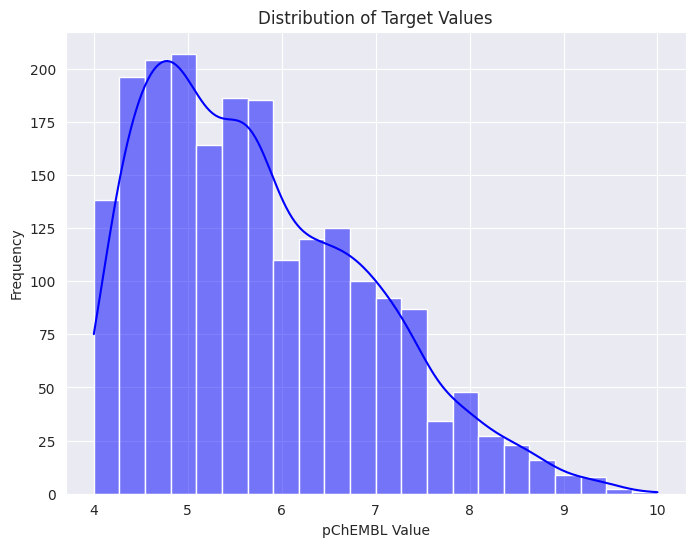

In [3]:
# Plot distribution of target values
plt.figure(figsize=(8, 6))
sns.histplot(target, kde=True, color='blue')
plt.title('Distribution of Target Values')
plt.xlabel('pChEMBL Value')
plt.ylabel('Frequency')
plt.show()


In [4]:
# Split data into training and test sets
smiles_train, smiles_valid, y_train, y_valid = train_test_split(smiles, target, test_size=0.2, random_state=42)

### Feature transformation: Descriptors

In [5]:
# descriptor = DatamolDescriptor(n_bins=10, kbd_strategy="uniform") #KBinsDiscretizer or binning
descriptor = DatamolDescriptor(discretize=False) # discretization  is true by default, and use_scaling if False by default
descriptor.fit(smiles_train)
smiles_train_transformed = descriptor.transform(smiles_train)
smiles_valid_transformed = descriptor.transform(smiles_valid)

100%|██████████| 417/417 [00:03<00:00, 116.17it/s]


KBinsDiscretizer maps the numerical values to categorical values.
Performance is observed to be lower when discretization is applied, and when descriptors are scaled(set use_scaling=True).


### Helper Functions
perform_testing  is to Train, evaluate and explain model. It returns an output folder with the metrics and interperability plots.

print_images_in_folder 


In [6]:
# Function to perform testing
def perform_testing(algorithm, default_params):
    # output folder
    algorithm_folder = "xgboost" if algorithm == 'xgboost' else "catboost"
    output_folder = f"../assets/{algorithm_folder}/default_params_{default_params}/"
    os.makedirs(output_folder, exist_ok=True)
    print('Output folder:', output_folder)
    
    # Instantiate the regressor
    regressor = Regressor(algorithm=algorithm, n_trials=200)

    # Train the model 
    regressor.train(smiles_train_transformed, y_train, default_params=default_params)

    # Evaluate model
    evaluation = regressor.evaluate(smiles_valid_transformed, y_valid, output_folder)#returns scores of evaluation metrics
    print(evaluation)
    
    # Interprete the model
    feature_names = descriptor.feature_names
    regressor.explain(smiles_train_transformed, feature_names, output_folder)
    return output_folder

In [7]:
# View all performance plots in the output folder
def print_images_in_folder(folder): 
    files = os.listdir(folder) 
    image_files = [file for file in files if file.endswith('.png')] 
    
    num_images = len(image_files)
    num_rows = (num_images + 1) // 2  
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
    axes = axes.flatten() 
     
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_file)
     
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

### XGBoost with Default Parameters

In [8]:
folder_xgboost_default_params = perform_testing(algorithm='xgboost', default_params=True)

Output folder: ../assets/xgboost/default_params_True/
{'Mean Squared Error': 0.6557, 'Root Mean Squared Error': 0.8097, 'Mean Absolute Error': 0.5867, 'R-squared Score': 0.5052, 'Explained Variance Score': 0.5054}


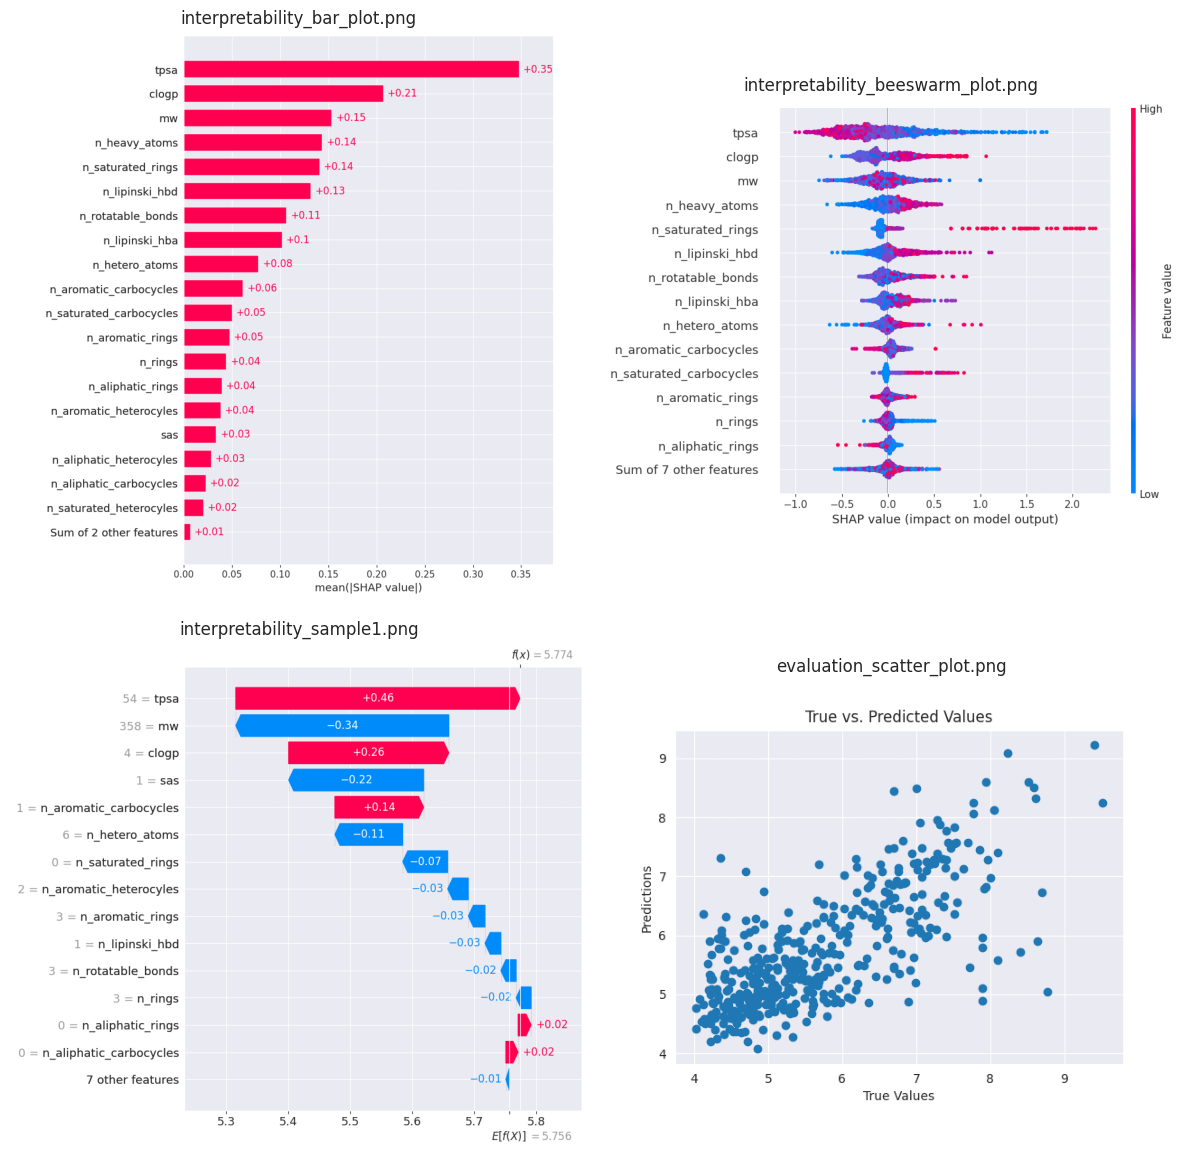

In [9]:
print_images_in_folder(folder_xgboost_default_params)

### XGBoost with Optuna

In [10]:
folder_xgboost_optimized_params = perform_testing(algorithm='xgboost', default_params=False)

[I 2024-03-23 15:27:35,261] A new study created in memory with name: no-name-19de5468-04ea-4278-90b5-a99217aebb13


Output folder: ../assets/xgboost/default_params_False/


[I 2024-03-23 15:27:35,477] Trial 0 finished with value: 0.2471291467606166 and parameters: {'lambda': 1, 'alpha': 0, 'gamma': 15, 'learning_rate': 0.8599218698024141, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'n_estimators': 125, 'min_child_weight': 19, 'max_depth': 18, 'subsample': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.2471291467606166.
[I 2024-03-23 15:27:35,995] Trial 1 finished with value: 0.28122754002336003 and parameters: {'lambda': 3, 'alpha': 1, 'gamma': 7, 'learning_rate': 0.8732530752134827, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'n_estimators': 72, 'min_child_weight': 100, 'max_depth': 15, 'subsample': 1.0, 'random_state': 0}. Best is trial 1 with value: 0.28122754002336003.
[I 2024-03-23 15:27:36,968] Trial 2 finished with value: 0.34361195960803304 and parameters: {'lambda': 4, 'alpha': 1, 'gamma': 3, 'learning_rate': 0.6799260531329042, 'colsample_bytree': 0.5, 'colsample_bynode': 0.8, 'n_estimators': 136, 'min_child_weight': 47, 'ma

Best parameters for XGBoost: {'lambda': 1, 'alpha': 2, 'gamma': 0, 'learning_rate': 0.42914239939466864, 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'n_estimators': 134, 'min_child_weight': 2, 'max_depth': 17, 'subsample': 0.8, 'random_state': 0}
{'Mean Squared Error': 0.7059, 'Root Mean Squared Error': 0.8402, 'Mean Absolute Error': 0.6061, 'R-squared Score': 0.4673, 'Explained Variance Score': 0.4673}


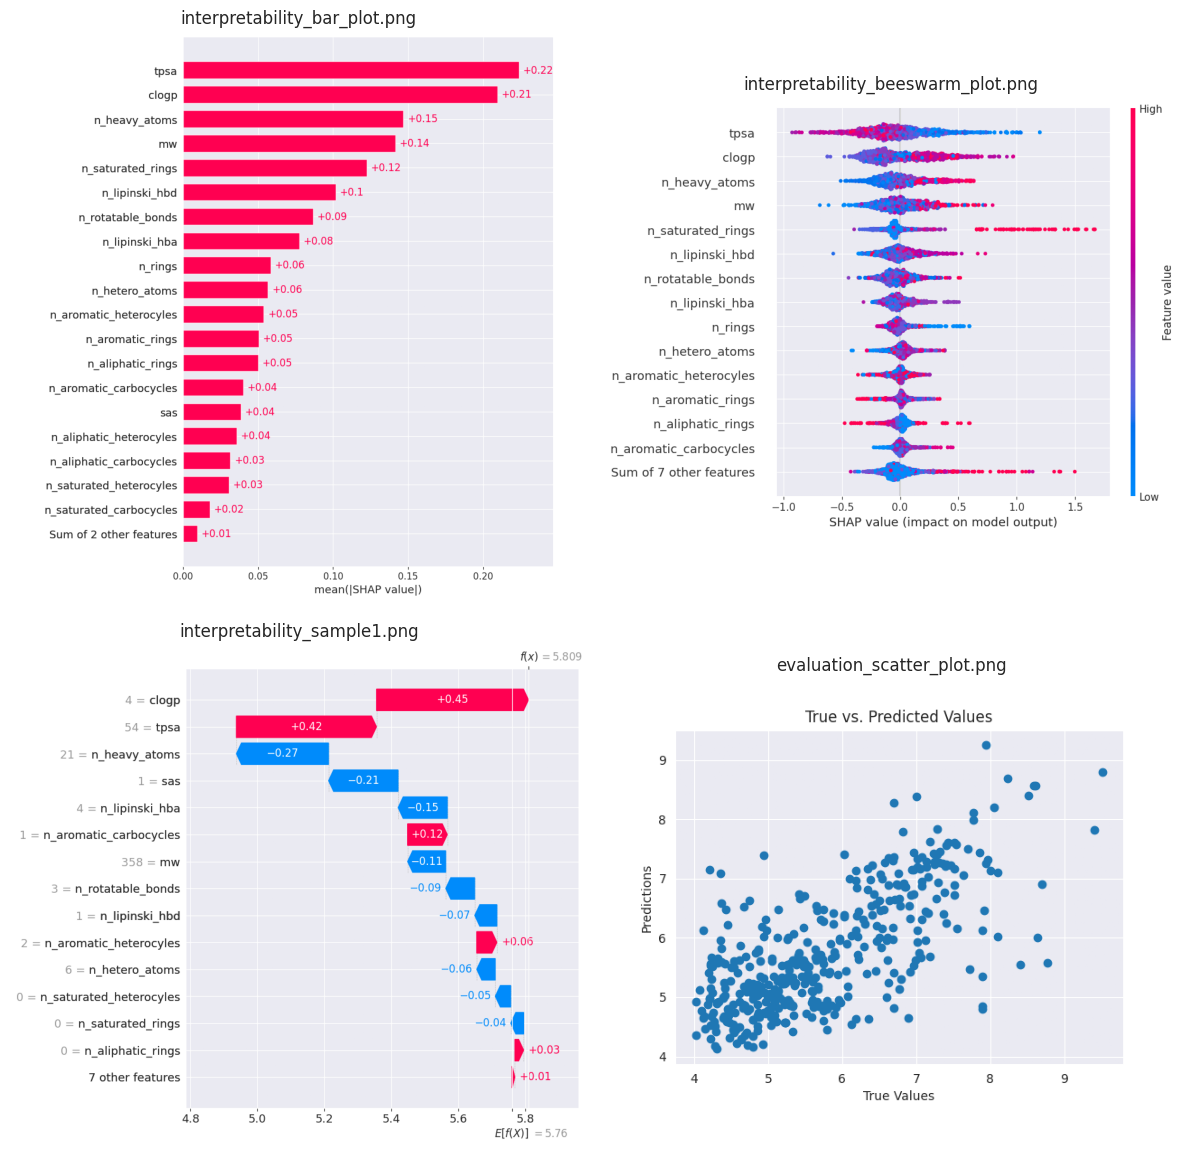

In [11]:
print_images_in_folder(folder_xgboost_optimized_params)

### CatBoost with Default Parameters

In [12]:
folder_catboost_default_params = perform_testing(algorithm='catboost', default_params=True)

Output folder: ../assets/catboost/default_params_True/
{'Mean Squared Error': 0.5919, 'Root Mean Squared Error': 0.7693, 'Mean Absolute Error': 0.571, 'R-squared Score': 0.5533, 'Explained Variance Score': 0.5537}


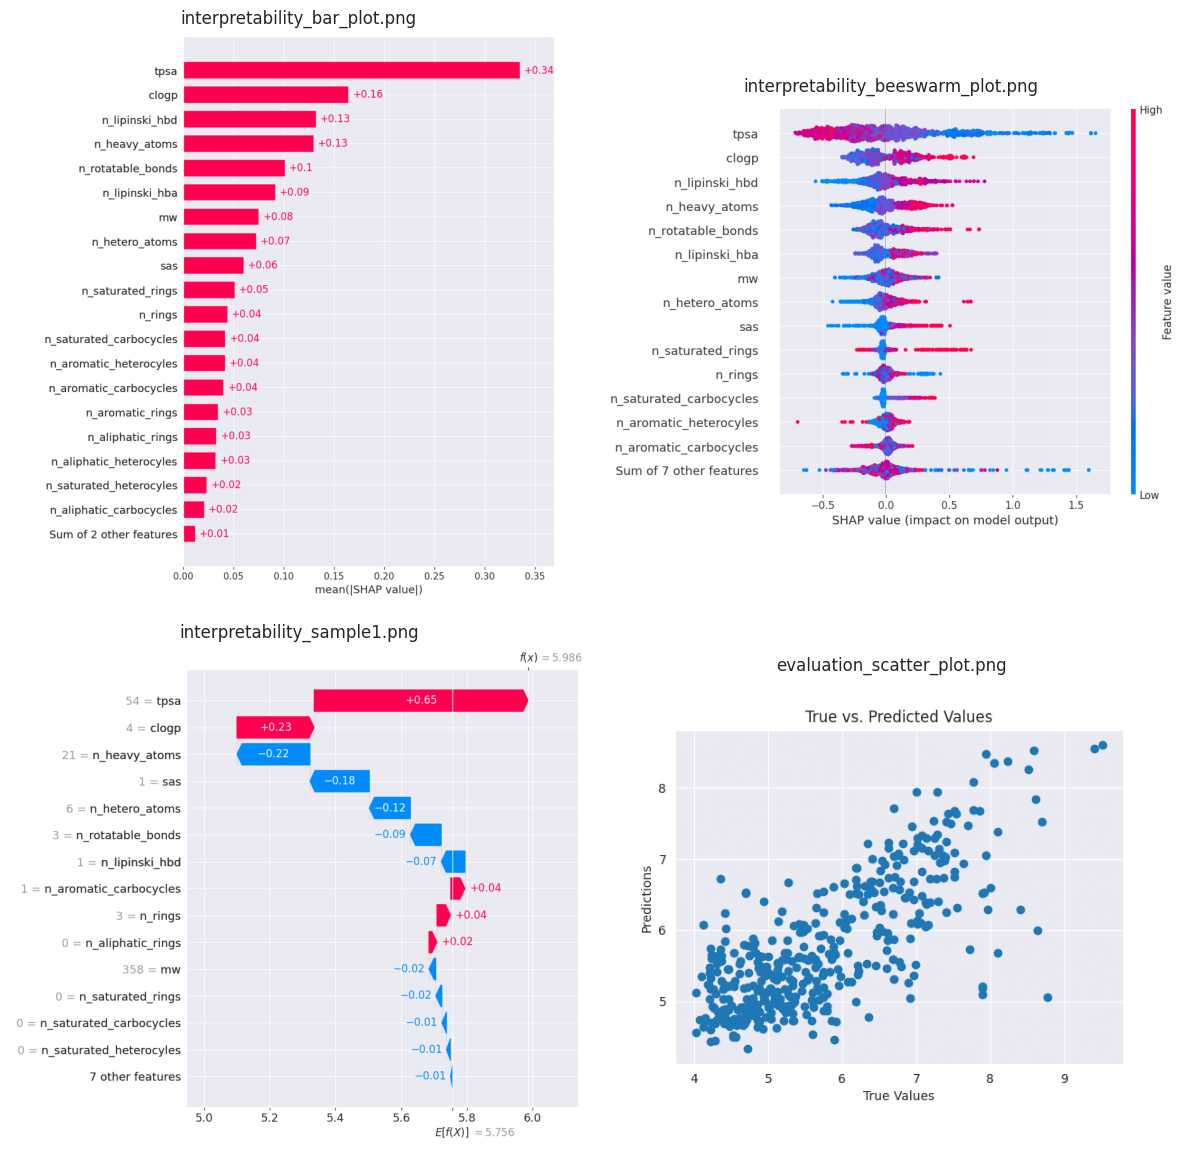

In [13]:
print_images_in_folder(folder_catboost_default_params)

### CatBoost with Optuna
Goal is to minimize RMSE. RMSE is the default loss function used.

In [14]:
folder_catboost_optimized_params = perform_testing(algorithm='catboost', default_params=False)

[I 2024-03-23 15:28:30,283] A new study created in memory with name: no-name-fe55b77d-8269-4034-ba61-05ef0d948b6b
[I 2024-03-23 15:28:30,436] Trial 0 finished with value: 0.8435861687437974 and parameters: {'iterations': 1436, 'learning_rate': 0.9851039305222385, 'reg_lambda': 1.7701477872097153, 'subsample': 1.0, 'random_strength': 1.8836731879615405, 'depth': 8, 'leaf_estimation_iterations': 10}. Best is trial 0 with value: 0.8435861687437974.


Output folder: ../assets/catboost/default_params_False/


[I 2024-03-23 15:28:30,601] Trial 1 finished with value: 0.6696194856688171 and parameters: {'iterations': 1350, 'learning_rate': 0.5396653971721949, 'reg_lambda': 6.190358701703753, 'subsample': 0.6, 'random_strength': 7.911071626797502, 'depth': 5, 'leaf_estimation_iterations': 6}. Best is trial 1 with value: 0.6696194856688171.
[I 2024-03-23 15:28:32,070] Trial 2 finished with value: 0.5825734515181615 and parameters: {'iterations': 1186, 'learning_rate': 0.11361038916745028, 'reg_lambda': 6.566162593145604, 'subsample': 0.8, 'random_strength': 1.8381818309537081, 'depth': 10, 'leaf_estimation_iterations': 5}. Best is trial 2 with value: 0.5825734515181615.
[I 2024-03-23 15:28:32,374] Trial 3 finished with value: 0.6336108688107885 and parameters: {'iterations': 1083, 'learning_rate': 0.2980857813490682, 'reg_lambda': 8.72110875136321, 'subsample': 0.7, 'random_strength': 2.4631064109627525, 'depth': 7, 'leaf_estimation_iterations': 8}. Best is trial 2 with value: 0.5825734515181615

Best parameters for CatBoost: {'iterations': 635, 'learning_rate': 0.11619912722889149, 'reg_lambda': 7.389943030661719, 'subsample': 0.7, 'random_strength': 4.8197679069673205, 'depth': 9, 'leaf_estimation_iterations': 7}
{'Mean Squared Error': 0.6177, 'Root Mean Squared Error': 0.786, 'Mean Absolute Error': 0.5695, 'R-squared Score': 0.5338, 'Explained Variance Score': 0.5338}


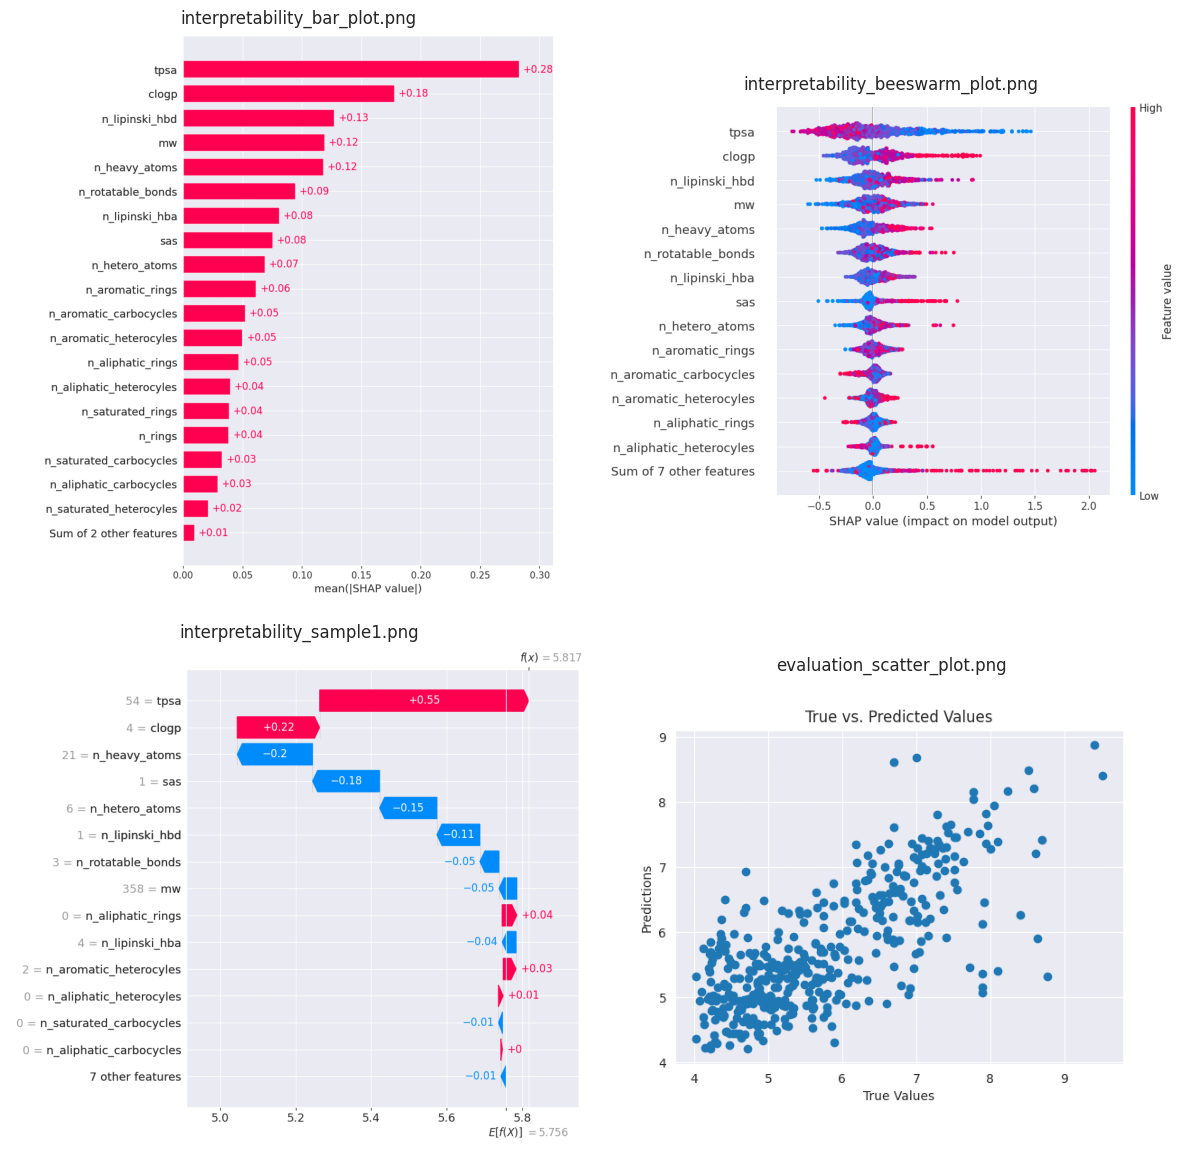

In [15]:
print_images_in_folder(folder_catboost_optimized_params)

### Top Features in each case

In [16]:
def print_interpretability_bar_plots():
    # Scan the "../assets" directory for output folders
    output_folders = [os.path.join("../assets", folder) for folder in os.listdir("../assets/") if os.path.isdir(os.path.join("../assets", folder))]
    
    print(output_folders)
    for folder in output_folders:
        print(f"Output Folder: {folder}")
        
        # Iterate over all subdirectories in the current output folder
        for root, dirs, files in os.walk(folder):
            # Check if the file exists in the current subdirectory
            if 'interpretability_bar_plot.png' in files:
                interpretability_bar_plot_path = os.path.join(root, 'interpretability_bar_plot.png')
                print(f"Interpretability Bar Plot: {root.split('/')[2:]}") 
                interpretability_bar_plot = plt.imread(interpretability_bar_plot_path)
                plt.figure(figsize=(16, 10))  # Adjust the figure size as needed
                plt.imshow(interpretability_bar_plot)
                plt.axis('off')
                plt.show()


['../assets/catboost', '../assets/xgboost']
Output Folder: ../assets/catboost
Interpretability Bar Plot: ['catboost', 'default_params_True']


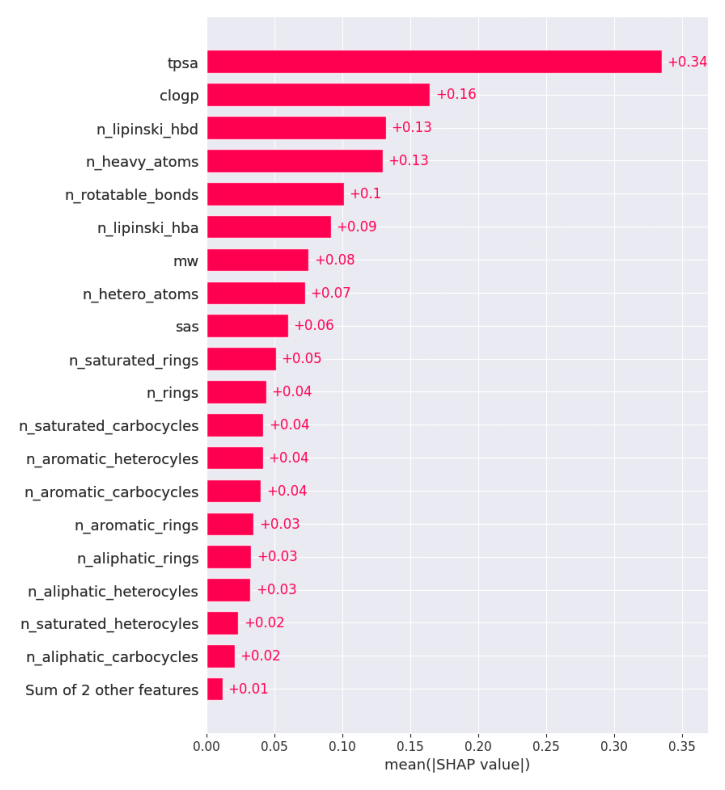

Interpretability Bar Plot: ['catboost', 'default_params_False']


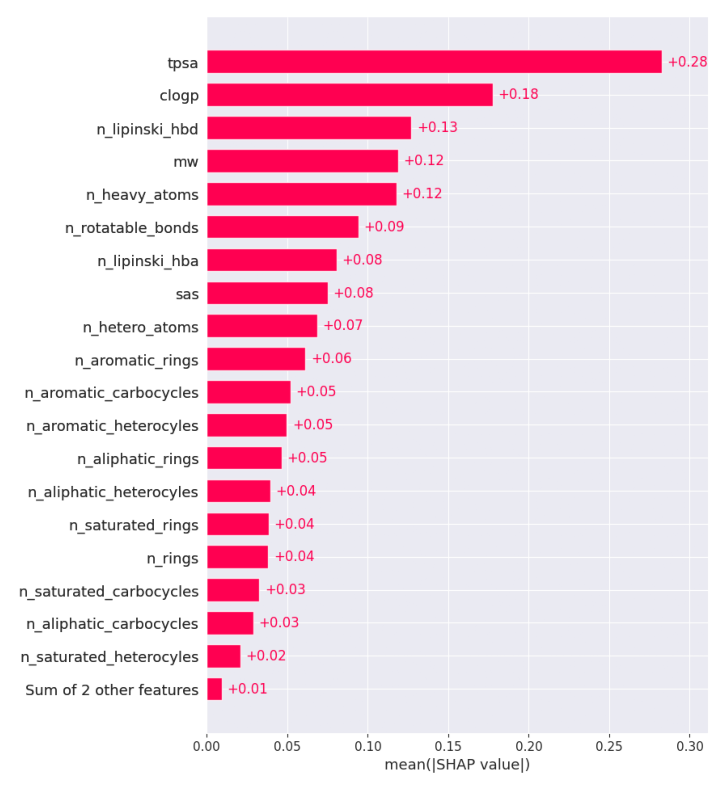

Output Folder: ../assets/xgboost
Interpretability Bar Plot: ['xgboost', 'default_params_True']


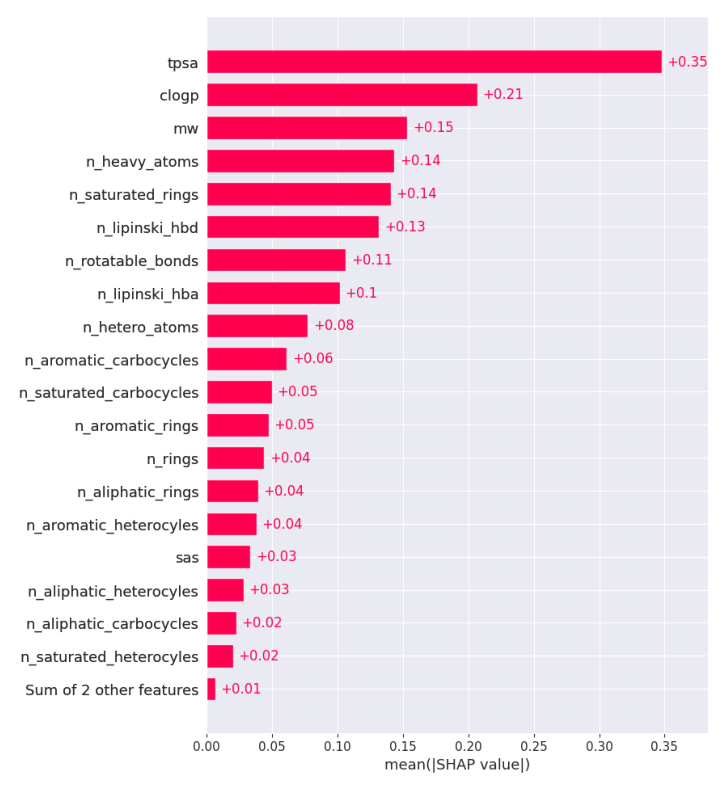

Interpretability Bar Plot: ['xgboost', 'default_params_False']


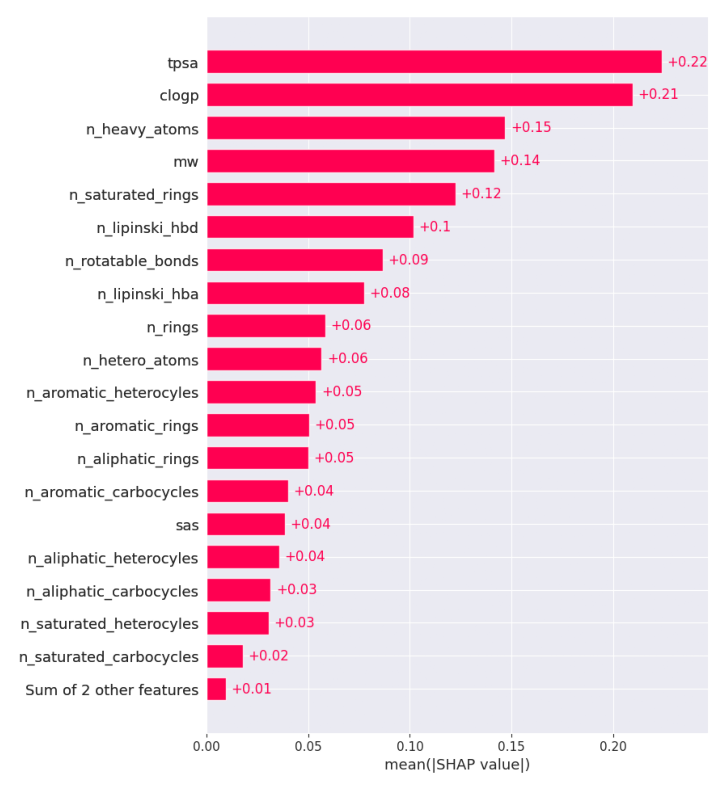

In [17]:
print_interpretability_bar_plots()